In [184]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.interpolate import spline
import seaborn as sns

### Experiment setup:

In [239]:
def initTemplate():
    # Instantiating a template to be filled in with experimental data
    return [[round(p, 2),q] for p,q in list(zip(np.arange(0,1.01,.01).tolist(), [0]*101))]

In [76]:
# Basic helper function: simulate rolling two die and see how long it takes to roll doubles.

def countToDoubles(die1=range(1,7), die2=range(1,7), turn=1):
    '''
    Calculate how many turns it takes to roll doubles.
    '''
    roll = random.choice(die1), random.choice(die2)
    if roll[0] == roll[1]:
        return turn
    else:
        turn += 1
        return countToDoubles(die1, die2, turn)

In [109]:
# Intermediate helper function: simulate rolling to get out of Monopoly jail, track binary outcome.

def simulateGettingOutOfJail(n):
    '''
    Generate outcomes of trying to get out of 
    Monopoly jail by rolling doubles (binary version).
    n = number of simulations
    '''
    # Success outcome to be tracked for frequency:
    getOutOfJailFree = 0
    
    for i in range(0,n):
        roll = countToDoubles()
        if roll <= 3:
            getOutOfJailFree += 1
    
    return getOutOfJailFree/n

In [235]:
def runExperiment(trials=10, n=10):
    '''
    A Monte Carlo-style simulation of a number of games (trials), each 
    consisting of a set number of rounds (n) of trying to roll doubles
    to get out of jail.
    '''
    data = initTemplate()
    for i in range(0, trials):
        result = round(simulateGettingOutOfJail(n), 2)
        data[int(result*100)][1] += 1
        #data[int(result*10)][1] += 1
    
    return data

### Analysis setup:

In [152]:
def logData(data, trials):
    '''
    Changes data from counts to percentiles.
    data = list of lists of form [bin,count]
    '''
    newData = []
    for i in data:
        newData.append([i[0], i[1]/trials])
    
    return newData

In [277]:
def removeZeros(data):
    '''
    Remove zero-counts to de-sparse the space.
    ''' 
    return [[i,j] for i,j in data if j > 0.0 and j <= 1]

In [305]:
def calculateStd(data):
    '''
    Calculates standard deviation from a non-sparse 
    (i.e., zeros removed) list of data points (data).
    '''
    return np.std(data)

### Running the experiment, analysis:

In [344]:
def compileExperimentalData(n=range(2,51), trials=100):
    '''
    Run the experiment for a given range (n) of rolling-
    doubles-to-get-out-of-jail occurrence within a single 
    game; simulate outcomes for each number (i) in the range 
    a certain number of times (trials).
    
    Perform analysis on data generated and return results 
    in the form 
        {
         'i_1': {'data': c_1, 'std': d_1}, 
         ..., 
         'i_n': {'data': c_n, 'std': d_n}
        }.
    '''
    results = {}
    
    for i in n:
        a = runExperiment(trials, i)
        b = logData(a, trials)
        c = removeZeros(b)
        d = calculateStd(c)
        #d = smoothDataForGraphing(c)
        results[str(i)] = {'data': c, 'std': d}
        
    return results

In [369]:
testData = compileExperimentalData()

In [370]:
testData['50']

{'data': [[0.26, 0.04],
  [0.28, 0.01],
  [0.3, 0.02],
  [0.32, 0.02],
  [0.34, 0.05],
  [0.36, 0.11],
  [0.38, 0.1],
  [0.4, 0.05],
  [0.42, 0.1],
  [0.44, 0.13],
  [0.46, 0.13],
  [0.48, 0.08],
  [0.5, 0.02],
  [0.52, 0.09],
  [0.54, 0.04],
  [0.57, 0.01]],
 'std': 0.18842454350150353}

In [373]:
data100trials = compileExperimentalData(range(2,101),100)

In [356]:
data1000trials = compileExperimentalData(range(2,101),1000)

### Graphing results:

In [314]:
def smoothDataForGraphing(data):
    '''
    Smooth out curve representations of data.
    '''
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    xSmooth = np.linspace(0, 1, 1000)
    ySmooth = spline(x, y, xSmooth)
    return {'x': xSmooth, 'y': ySmooth}
#     sns.set_style("darkgrid")
#     plt.plot(xSmooth, ySmooth)
#     plt.show()

In [382]:
def graphData(data):
    '''
    Graph experimental results.
    
    This function takes in data of the form
        {
         'i_1': {'data': c_1, 'std': d_1}, 
         ..., 
         'i_n': {'data': c_n, 'std': d_n}
        }.
    '''
    # Graphical setup
    numPlots = len(data)
    colormap = plt.cm.gist_earth
    plt.gca().set_color_cycle(colormap(i) for i in np.linspace(0, 0.9, numPlots))
    #sns.set_style("darkgrid")
    plt.xlabel('Probability of success at rolling doubles to get out of jail', fontsize=16)
    plt.ylabel('Percentile frequency', fontsize=16)
    plt.rcParams['figure.figsize'] = [20,10]
    plt.title('Getting Out of Jail Free: What Are the Chances?', fontsize=20)
    
    # Plotting data
    for k,v in data.items():
        if int(k) > 9:  # Increase legibility of graph
            graphableData = smoothDataForGraphing(v['data'])
            plt.plot(graphableData['x'], abs(graphableData['y']), label='n = ' + k)
    
    #plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=5, mode='expand', borderaxespad=0.)
    plt.show()

In [384]:
def graphStd(data):
    '''
    Graph standard deviations of experimental results.
    
    This function takes in data of the form
        {
         'i_1': {'data': c_1, 'std': d_1}, 
         ..., 
         'i_n': {'data': c_n, 'std': d_n}
        }.
    '''
    plt.xlabel('Number of instances of trying to roll doubles to\nget out of jail in a single trial (rounds per trial)', fontsize=16)
    plt.ylabel('Standard deviation of experimental\nresults (percentile variance)', fontsize=16)
    plt.rcParams['figure.figsize'] = [20,10]
    plt.title('Getting Out of Jail Free: How Variable Are the Chances?', fontsize=20)
     
    graphableData = []
    for k,v in data.items():
        graphableData.append([int(k), v['std']])
    x = [i[0] for i in graphableData]
    y = [i[1] for i in graphableData]
    
    plt.plot(x,y, 'b^')
    plt.show()   

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


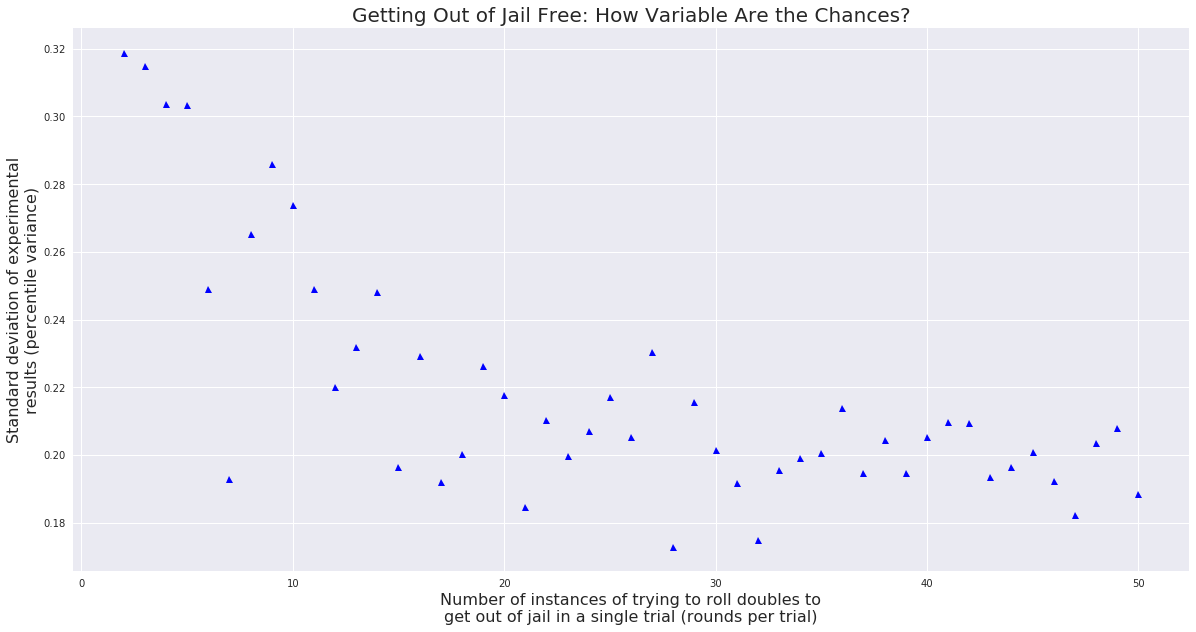

In [385]:
graphStd(testData)

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


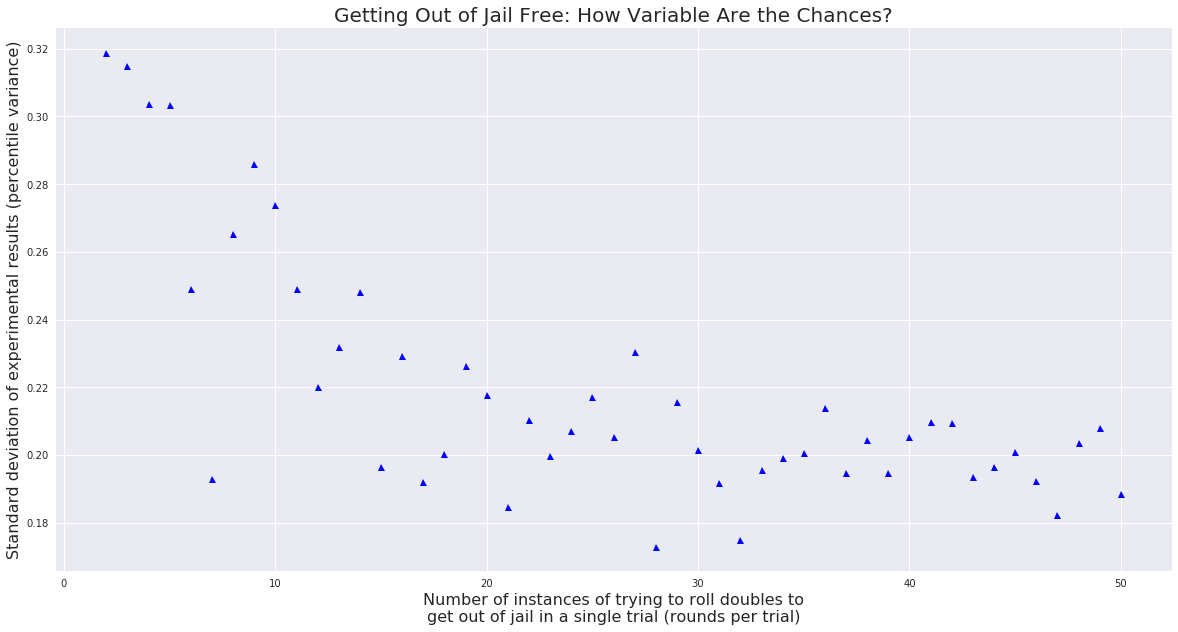

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


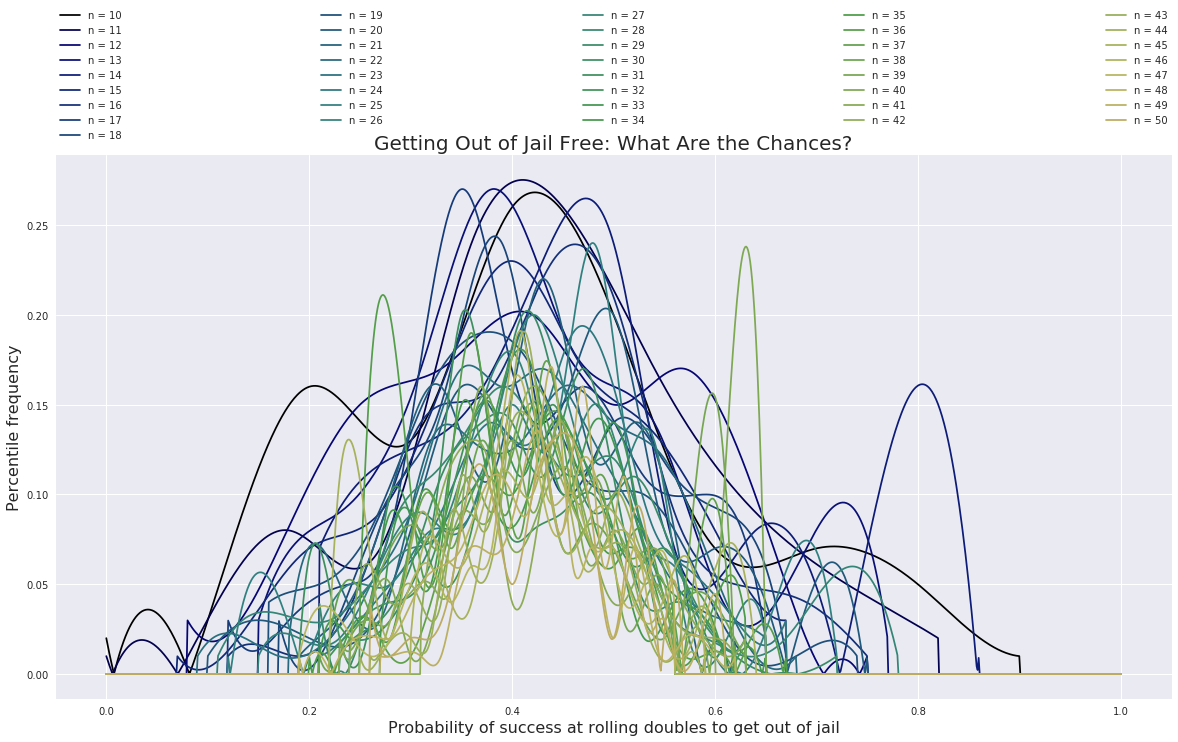

In [383]:
graphStd(testData)
graphData(testData)

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


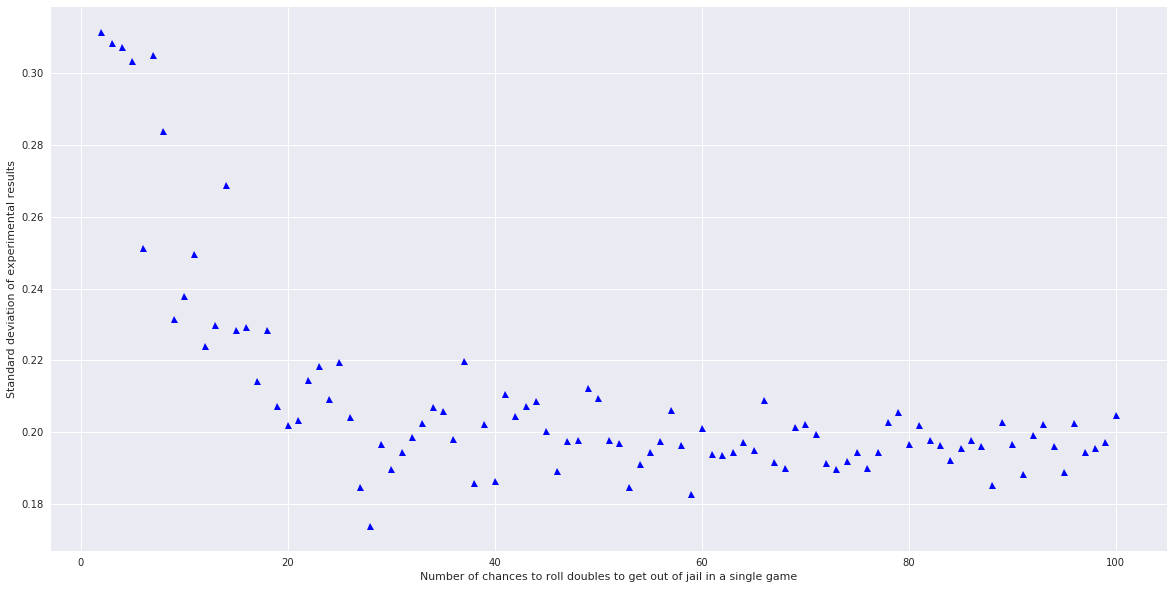

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


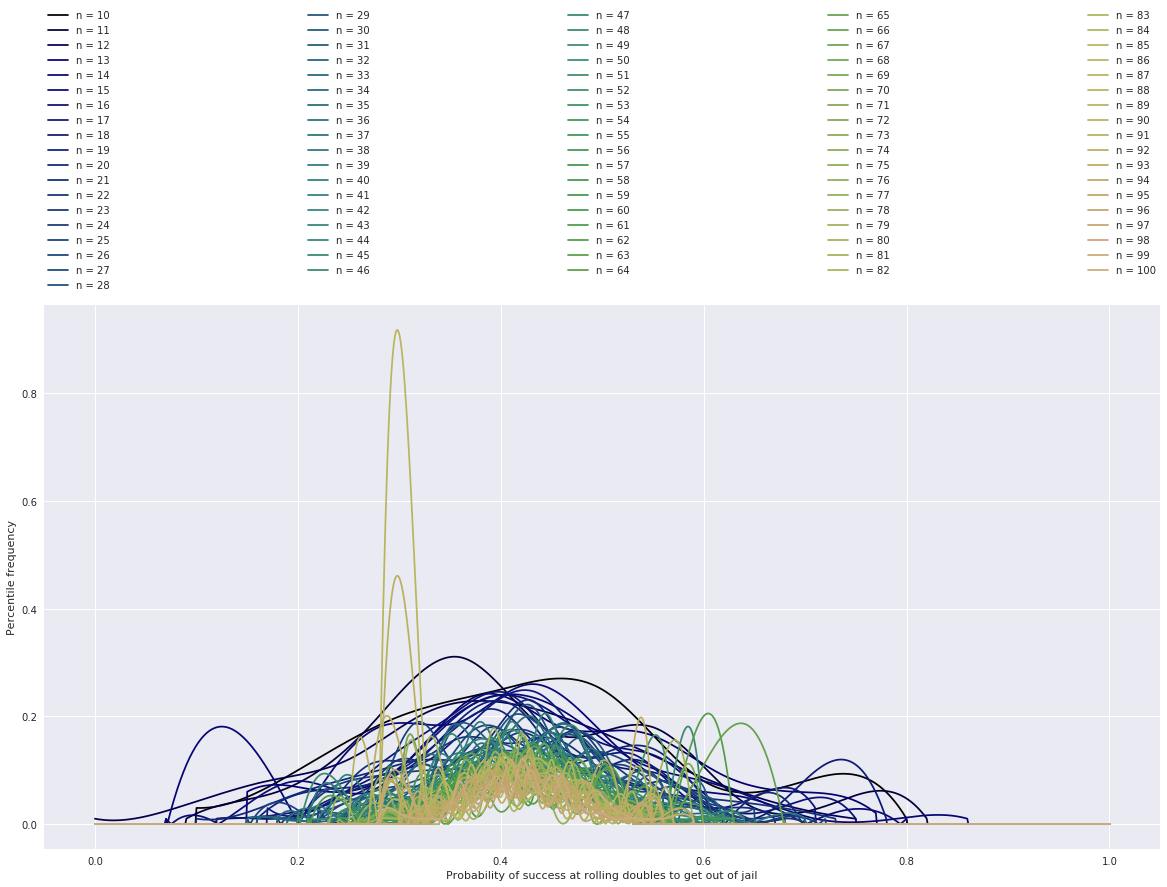

In [374]:
graphStd(data100trials)
graphData(data100trials)

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


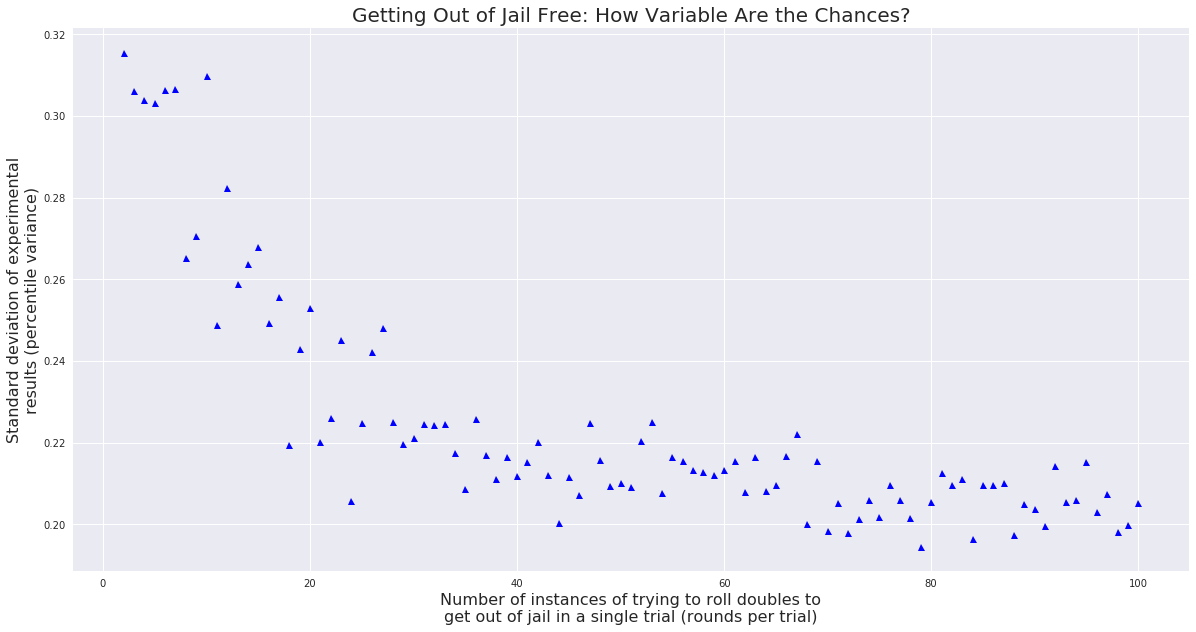

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


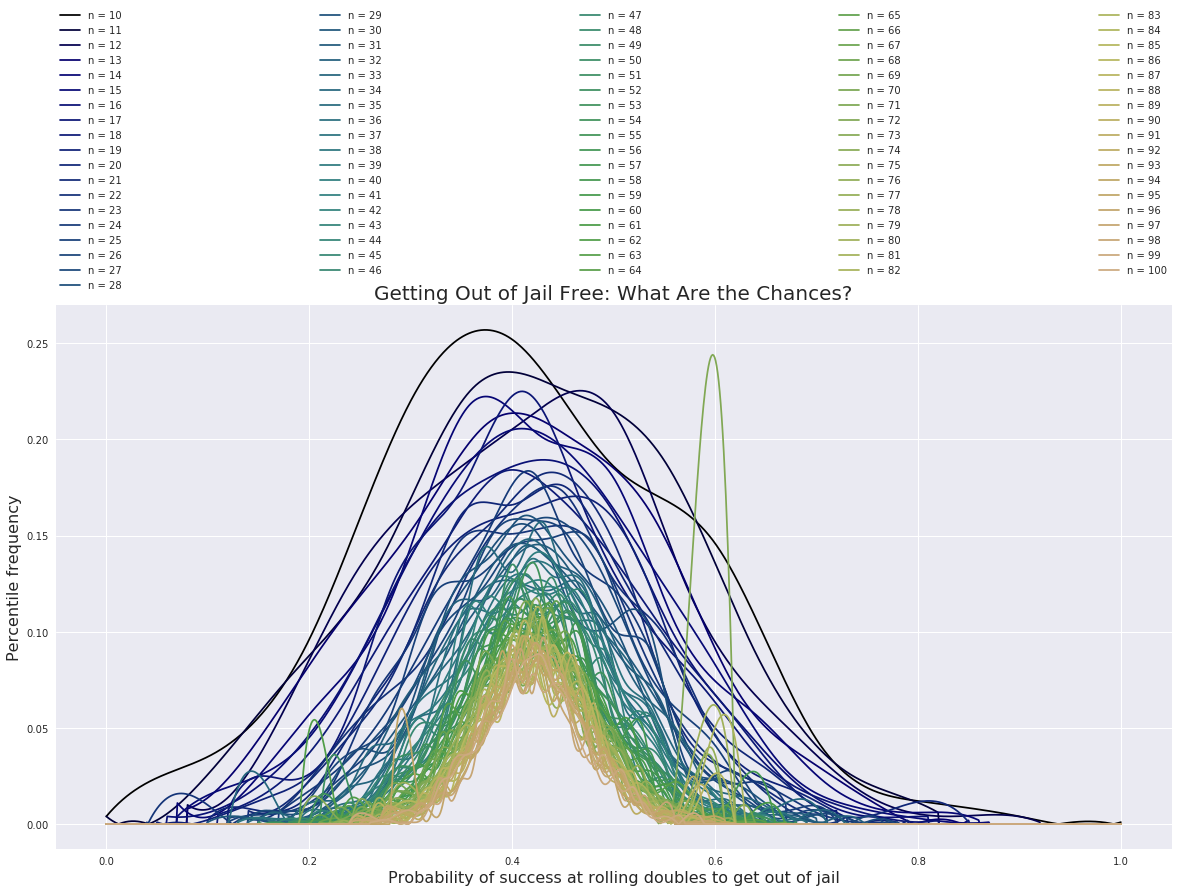

In [386]:
graphStd(data1000trials)
graphData(data1000trials)

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


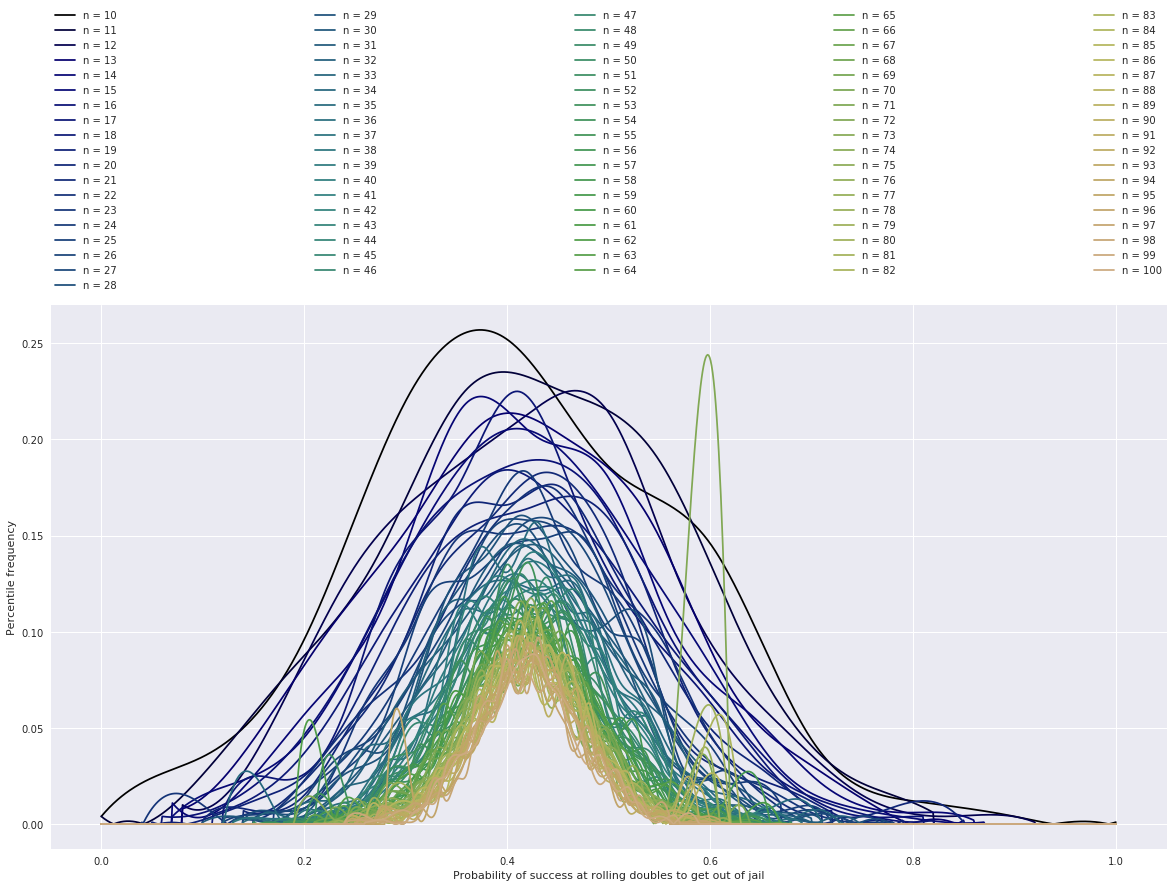

In [363]:
graphData(data1000trials)

In [364]:
nVsStd = []
for k,v in data1000trials.items():
    nVsStd.append([int(k), v['std']])

In [365]:
nVsStd

[[2, 0.31551580344290553],
 [3, 0.30609679841514187],
 [4, 0.30395789182056121],
 [5, 0.30312767753685721],
 [6, 0.30629484261450585],
 [7, 0.30661977675942559],
 [8, 0.26525612622520145],
 [9, 0.27058302393074507],
 [10, 0.30968572445930453],
 [11, 0.24889907593239474],
 [12, 0.28225472054994449],
 [13, 0.2589634136065882],
 [14, 0.26365380025497243],
 [15, 0.26798908173467456],
 [16, 0.24932168332326801],
 [17, 0.25569802363323191],
 [18, 0.21936366304989224],
 [19, 0.24304777765332933],
 [20, 0.25295941703495972],
 [21, 0.22015622478960134],
 [22, 0.22606404862700452],
 [23, 0.24523170316110052],
 [24, 0.20566116500909795],
 [25, 0.22475764725588315],
 [26, 0.24213635710503856],
 [27, 0.24805179168477035],
 [28, 0.22498116799313914],
 [29, 0.21956672533651359],
 [30, 0.22110128398039161],
 [31, 0.22451933885081157],
 [32, 0.22438437727576332],
 [33, 0.22447601035383877],
 [34, 0.21744264694199544],
 [35, 0.20877980819573838],
 [36, 0.2257365169157442],
 [37, 0.21699927995272245],
 [

### Notes from earlier

/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """
/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


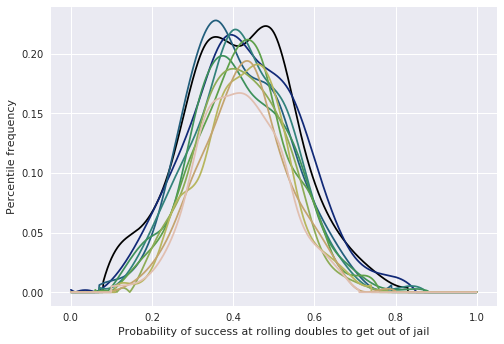

In [300]:
trials = 1000

numPlots = 10 #98
colormap = plt.cm.gist_earth
plt.gca().set_color_cycle(colormap(i) for i in np.linspace(0, 0.9, numPlots))
sns.set_style("darkgrid")
plt.xlabel('Probability of success at rolling doubles to get out of jail')
plt.ylabel('Percentile frequency')

for i in range(12, 22):
    a = runExperiment(trials, i)
    b = logData(a, trials)
    c = removeZeros(b)
    d = smoothDataForGraphing(c)
    plt.plot(d['x'], abs(d['y']))

plt.show()

In [301]:
c

[[0.1, 0.005],
 [0.14, 0.006],
 [0.19, 0.014],
 [0.24, 0.039],
 [0.28, 0.078],
 [0.33, 0.147],
 [0.38, 0.164],
 [0.43, 0.166],
 [0.48, 0.145],
 [0.52, 0.118],
 [0.56, 0.067],
 [0.62, 0.034],
 [0.67, 0.015],
 [0.71, 0.002]]

In [302]:
#Standard dev - write func
np.std(c)

0.21852353583604153

In [303]:
a5 = runExperiment(1000, 5)
b5 = logData(a5, 1000)
c5 = removeZeros(b5)
std5 = np.std(c5)

a15 = runExperiment(1000, 15)
b15 = logData(a15, 1000)
c15 = removeZeros(b15)
std15 = np.std(c15)

a25 = runExperiment(1000, 25)
b25 = logData(a25, 1000)
c25 = removeZeros(b25)
std25 = np.std(c25)

In [304]:
print(std5, std15, std25)

0.305203302006 0.244382157468 0.237179504351


In [266]:
#smoothDataForGraphing(a2)['x']

In [ ]:
numPlots = 10

colormap = plt.cm.gist_nchar
plt.gca().set_color_cycle(colormap(i) for i in np.linspace(0, 0.9, numPlots))

sns.set_style("darkgrid")
plt.plot(xSmooth, ySmooth)
plt.show()

/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """
/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


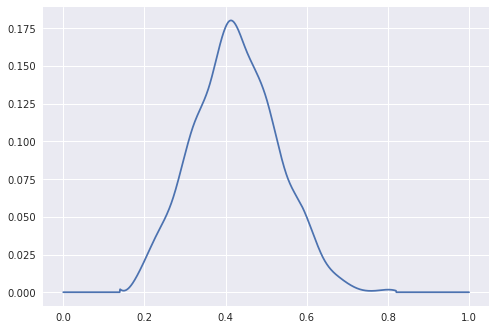

In [259]:
graph(removeZeros(a2))

In [220]:
test = runExperiment(1000,20)
a = logData(test, 1000)

In [242]:
test2 = runExperiment(1000,22)
a2 = logData(test2, 1000)

In [228]:
x = [i[0] for i in a2]
y = [i[1] for i in a2]
xSmooth = np.linspace(0, 1, 101)
ySmooth = spline(x, y, xSmooth)

/home/bellent000/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.


/home/bellent000/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


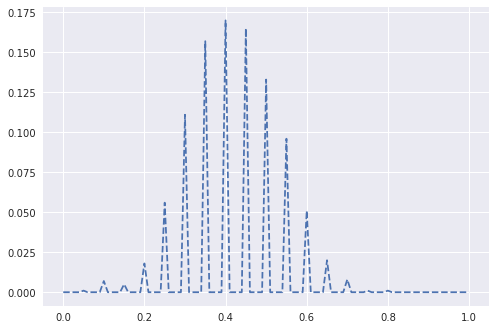

In [229]:
sns.set_style("darkgrid")
plt.plot(xSmooth, ySmooth, '--')
plt.show()

In [7]:
avg=0
for i in range(0,10):
    avg += countToDoubles()
print(avg/10)

6.2


In [ ]:
def getOutOfJail(n=1000):
    '''
    A Monte Carlo style simulation of outcomes of
    trying to get out of Monopoly jail by rolling doubles.
    n = number of simulations
    '''
    turnFrequencies = {'1': 0, '2': 0, '3': 0, 'pay50': 0}
    for i in range(0,n):
        roll = countToDoubles()
        if roll == 1:
            turnFrequencies['1'] += 1
        elif roll == 2:
            turnFrequencies['2'] += 1
        elif roll == 3:
            turnFrequencies['3'] += 1
        else:
            turnFrequencies['pay50'] += 1
    
    return turnFrequencies

In [44]:
def runSimulations(n=100, turns=100):
    results = {'1': 0, '2': 0, '3': 0, 'pay50': 0}
    for i in range(0,n):
        for k,v in getOutOfJail(turns).items():
            results[k] += v
    
    for k2,v2 in results.items():
        results[k2] /= n
        
    return results

In [52]:
data = {}

for i in range(2,101):
    data[i] = runSimulations(100,i)

KeyboardInterrupt: 

In [49]:
runSimulations(100,12)

{'1': 1.81, '2': 1.51, '3': 1.6, 'pay50': 7.08}

In [37]:
getOutOfJail(12)

{'1': 2, '2': 1, '3': 3, 'pay50': 6}

In [38]:
getOutOfJail(100)

{'1': 17, '2': 14, '3': 7, 'pay50': 62}

In [39]:
getOutOfJail(1000)

{'1': 169, '2': 135, '3': 126, 'pay50': 570}